In [19]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [55]:
ffs = all_pitches[all_pitches['TaggedPitchType'].isin(['FourSeamFastBall', 'Fastball'])]
print(ffs.shape)

(125719, 167)


In [56]:
ffs_rr = ffs[(ffs['PitcherThrows'] == 'Right') & (ffs['BatterSide'] == 'Right')]
ffs_rl = ffs[(ffs['PitcherThrows'] == 'Right') & (ffs['BatterSide'] == 'Left')]
ffs_lr = ffs[(ffs['PitcherThrows'] == 'Left') & (ffs['BatterSide'] == 'Right')]
ffs_ll = ffs[(ffs['PitcherThrows'] == 'Left') & (ffs['BatterSide'] == 'Left')]

print(ffs_rr.shape)
print(ffs_rl.shape)
print(ffs_lr.shape)
print(ffs_ll.shape)

(47555, 167)
(36801, 167)
(26799, 167)
(14427, 167)


In [57]:
ffs_rr['whiff'] = np.where(ffs_rr['PitchCall']=='StrikeSwinging',1,0)
ffs_rl['whiff'] = np.where(ffs_rl['PitchCall']=='StrikeSwinging',1,0)
ffs_lr['whiff'] = np.where(ffs_lr['PitchCall']=='StrikeSwinging',1,0)
ffs_ll['whiff'] = np.where(ffs_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_16244\2915248739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffs_rr['whiff'] = np.where(ffs_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_16244\2915248739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffs_rl['whiff'] = np.where(ffs_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_16244\2915248739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [58]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [59]:
ffs_rr_X = ffs_rr[preds]
ffs_rr_y = ffs_rr['whiff']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(ffs_rr_X, ffs_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.16%


ROC AUC: 0.5105


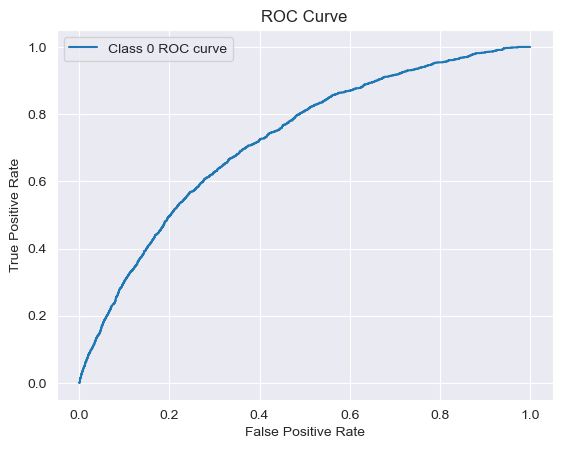

In [79]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [80]:
# Get unique values
unique_values = ffs_rr['Pitcher'].unique()

print(len(unique_values))

# Create a dictionary to store subsets
subsets = {value: ffs_rr[ffs_rr['Pitcher'] == value] for value in unique_values}

1444


In [81]:
def rr_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)

    


In [109]:
rr_ffs_stuff('Cijntje, Jurrangelo')

71.169365

In [84]:
ffs_rl_X = ffs_rl[preds]
ffs_rl_y = ffs_rl['whiff']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(ffs_rl_X, ffs_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.37%


In [86]:
# Get unique values
unique_values = ffs_rl['Pitcher'].unique()

print(len(unique_values))

# Create a dictionary to store subsets
subsets = {value: ffs_rl[ffs_rl['Pitcher'] == value] for value in unique_values}

1426


In [87]:
def rl_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [88]:
rl_ffs_stuff('Allsup, Chase')

136.41568

In [89]:
ffs_lr_X = ffs_lr[preds]
ffs_lr_y = ffs_lr['whiff']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(ffs_lr_X, ffs_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.05%


In [92]:
# Get unique values
unique_values = ffs_lr['Pitcher'].unique()

print(len(unique_values))

# Create a dictionary to store subsets
subsets = {value: ffs_lr[ffs_lr['Pitcher'] == value] for value in unique_values}


513


In [93]:
def lr_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [95]:
lr_ffs_stuff('Myers, Carson')

83.66337

In [102]:
ffs_ll_X = ffs_ll[preds]
ffs_ll_y = ffs_ll['whiff']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(ffs_ll_X, ffs_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.49%


In [104]:
# Get unique values
unique_values = ffs_ll['Pitcher'].unique()

print(len(unique_values))

# Create a dictionary to store subsets
subsets = {value: ffs_ll[ffs_ll['Pitcher'] == value] for value in unique_values}


499


In [106]:
def ll_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [108]:
ll_ffs_stuff('Cijntje, Jurrangelo')

70.44514